In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
plt.rc('font', family='Arial')

from qtrendutils import linfit_utils as linfit
from qtrendutils import shapefile_utils as shp
from qtrendutils import mapplot_utils as mymaps
from qtrendutils import colorbar_utils as cbars
from qtrendutils import lineplot_utils as lineplot
from qtrendutils import calendar_utils as cal
import pandas as pd
import importlib 
importlib.reload(cal)

import warnings
warnings.filterwarnings('ignore')
import sys

### Read in the mask for the US southwest

In [2]:
dat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/"+
          "vaporpressures_ERA5.nc")

shpfile="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/shp/gadm36_USA_1.shp"
mask = shp.maskgen(shpfile, dat,
   ['California','Nevada','Utah','Arizona','New Mexico','Colorado'])

### Read in the land fraction on the CESM grid

In [3]:
landfrac = xr.open_dataset("../DATA_SORT/LANDFRAC_LENS2.nc")
landfrac = landfrac.landfrac
landfrac = landfrac.where(landfrac > 0, nan)
landfrac = landfrac.where(landfrac.lat > -60, nan) # omitting Antarctica

### Read in the vapor pressure trend map data

In [4]:
plotpath="/project/cas/islas/python_plots/qtrend_paper/figures/"
trendpath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/"

### ERA5

In [5]:
era5map = xr.open_dataset(trendpath+"vptrends_ERA5.nc")
era5map['lon'] = landfrac['lon'] ; era5map['lat'] = landfrac['lat']

### ISD

In [6]:
isddat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_ISD_fromhourly_ge4pd.nc")

# drop stations that have more than 48 months with less than 15 bad days
dropstations=[]
for istation in np.arange(0,isddat.station.size,1):
    test = isddat.nbaddays.isel(station=istation)
    test = test.where( test > 15, drop=True)
    if (test.size > 48):
        badstation = np.array_str(isddat.station.isel(station=istation).values)
        dropstations.append(badstation)
isddat = isddat.drop_sel(station=dropstations)

# drop the lons and lats for now
lons = isddat.lons ; lats = isddat.lats
isddat = isddat.drop_vars(['lons','lats'])

# compute the seasonal cycle
isd_seascyc = isddat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_deseas = isddat.groupby('time.month') - isd_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
isd_seascyc = isd_seascyc.rename({"month":"time"})
isd_seascyc['time'] = isddat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_seascyc_am = cal.calcannualmean(isd_seascyc)

# annual average of seasonalized anomalies
isd_deseas_am = cal.calcannualmean(isd_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_seascyc_am = isd_seascyc_am.expand_dims({"otheryrs":isd_deseas_am.year.size})
isd_seascyc_am = isd_seascyc_am.stack(z=("year","otheryrs"))
isd_seascyc_am = isd_seascyc_am.reset_index('z', drop=True).rename(z="year")
isd_seascyc_am = isd_seascyc_am.assign_coords({'year':isd_deseas_am.year})

# add back in the annual average climatology
isd_am = isd_seascyc_am + isd_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
isdmap = xr.apply_ufunc(linfit.compute_slope, isd_am, vectorize=True, input_core_dims=[['year']])*isd_am.year.size
isdmap = xr.merge([isdmap, lons, lats])
isdmap = isdmap.dropna('station')

### HadISDH

In [7]:
#----HadISDH
hadisdhdat = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/OBS/vaporpressures/vaporpressures_HadISDH.nc")
lons = hadisdhdat.lon ; lats = hadisdhdat.lat
hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])
hadisdhdat = hadisdhdat.vp_fromhadisdh

badvp = xr.where( np.isnan(hadisdhdat), 1, 0)
nbadvp = badvp.sum("time")
hadisdhdat = hadisdhdat.where( nbadvp < 48, drop=True)

# drop the lons and lats for now
#lons = hadisdhdat.lon ; lats = hadisdhdat.lat
#hadisdhdat = hadisdhdat.drop_vars(['lon','lat'])

# compute the seasonal cycle
hadisdh_seascyc = hadisdhdat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_deseas = hadisdhdat.groupby('time.month') - hadisdh_seascyc

# add the time axis back to the seasonal cycle for pcomputing annual average
hadisdh_seascyc = hadisdh_seascyc.rename({"month":"time"})
hadisdh_seascyc['time'] = hadisdhdat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_seascyc_am = cal.calcannualmean(hadisdh_seascyc)

# annual average of seasonalized anomalies
hadisdh_deseas_am = cal.calcannualmean(hadisdh_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_seascyc_am = hadisdh_seascyc_am.expand_dims({"otheryrs":hadisdh_deseas_am.year.size})
hadisdh_seascyc_am = hadisdh_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_seascyc_am = hadisdh_seascyc_am.reset_index('z', drop=True).rename(z="year")
hadisdh_seascyc_am = hadisdh_seascyc_am.assign_coords({'year':hadisdh_deseas_am.year})

# add back in the annual average climatology
hadisdh_am = hadisdh_seascyc_am + hadisdh_deseas_am

#isddat_am = cal.calcannualmean(isddat, skipna=False)
hadisdhmap = xr.apply_ufunc(linfit.compute_slope, hadisdh_am, vectorize=True, input_core_dims=[['year']])*hadisdh_am.year.size
hadisdhmap = hadisdhmap.rename('vp')
hadisdhmap = xr.merge([hadisdhmap, lons, lats])
#hadisdhmap = hadisdhmap.dropna('station')

### Read in the southwest data

#### Stations 

In [8]:
### ISD
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
isd_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
isd_sw_lons = isd_vp_swstat.lons ; isd_sw_lats = isd_vp_swstat.lats ; isd_sw_wgts = isd_vp_swstat.area_weights
isd_vp_swstat = isd_vp_swstat.drop_vars(['lons','lats', 'area_weights'])

# compute the seasonal cycle
isd_sw_seascyc = isd_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
isd_sw_deseas = isd_vp_swstat.groupby('time.month') - isd_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
isd_sw_seascyc = isd_sw_seascyc.rename({"month":"time"})
isd_sw_seascyc['time'] = isd_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
isd_sw_seascyc_am = cal.calcannualmean(isd_sw_seascyc)

# annual average of deseasonzlied anomalies
isd_sw_deseas_am = cal.calcannualmean(isd_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
isd_sw_seascyc_am = isd_sw_seascyc_am.expand_dims({"otheryrs":isd_sw_deseas_am.year.size})
isd_sw_seascyc_am = isd_sw_seascyc_am.stack(z=("year","otheryrs"))
isd_sw_seascyc_am = isd_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
isd_sw_seascyc_am = isd_sw_seascyc_am.assign_coords({'year':isd_sw_deseas_am.year})

# expand out the monthly seasonal cycle to have the appropriate length
isd_sw_seascyc = isd_sw_seascyc.expand_dims({"otheryrs":isd_sw_deseas_am.year.size}, axis=0)
isd_sw_seascyc = isd_sw_seascyc.stack(z=("otheryrs","time"))
isd_sw_seascyc = isd_sw_seascyc.reset_index('z', drop=True).rename(z='time')
isd_sw_seascyc = isd_sw_seascyc.assign_coords({'time':isd_vp_swstat.time})


# add back in the annual average climatology
isd_sw_am = isd_sw_seascyc_am + isd_sw_deseas_am
isd_sw_monthly = isd_sw_seascyc + isd_sw_deseas

isd_sw_am = xr.merge([isd_sw_am, isd_sw_lons, isd_sw_lats, isd_sw_wgts]) 
isd_sw_monthly = xr.merge([isd_sw_monthly, isd_sw_wgts])

# now take the average over stations
isd_vp_sw_am = (isd_sw_am*isd_sw_am.area_weights).sum('station') / np.sum(isd_sw_am.area_weights)
isd_vp_sw_am = isd_vp_sw_am.drop_vars(['lons','lats','area_weights'])

# take the average over stations for the monthly deseasonalize for calculating monthly trends
isd_vp_sw_monthly_values = (isd_sw_monthly*isd_sw_monthly.area_weights).sum('station', skipna=True) / np.sum(isd_sw_monthly.area_weights)

isd_vp_sw_am_to2019 = isd_vp_sw_am.sel(year=slice(1980,2019))

In [9]:
### HadISDH
basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
hadisdh_vp_swstat = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_swstations.nc').sel(time=slice("1980-01-01","2020-12-31"))

# drop the lons and lats and weights for now
hadisdh_sw_lons = hadisdh_vp_swstat.lon ; hadisdh_sw_lats = hadisdh_vp_swstat.lat ; hadisdh_sw_wgts = hadisdh_vp_swstat.area_weights
hadisdh_vp_swstat = hadisdh_vp_swstat.drop_vars(['lon','lat','area_weights'])

# compute the seasonal cycle
hadisdh_sw_seascyc = hadisdh_vp_swstat.groupby('time.month').mean('time', skipna=True)

# compute anomalies from the seasonal cycle
hadisdh_sw_deseas = hadisdh_vp_swstat.groupby('time.month') - hadisdh_sw_seascyc

# add the tim eaxis back to the seasonal cycle for computing annual averages
hadisdh_sw_seascyc = hadisdh_sw_seascyc.rename({"month":"time"})
hadisdh_sw_seascyc['time'] = hadisdh_vp_swstat.time.sel(time=slice("1980-01-01","1980-12-31"))

# seasonal cycle annual average
hadisdh_sw_seascyc_am = cal.calcannualmean(hadisdh_sw_seascyc)

# annual average of deseasonzlied anomalies
hadisdh_sw_deseas_am = cal.calcannualmean(hadisdh_sw_deseas, skipna=True)

# expand out the seasonal cycle to have the appropriate length
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size})
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.stack(z=("year","otheryrs"))
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.reset_index('z', drop=True).rename(z='year')
hadisdh_sw_seascyc_am = hadisdh_sw_seascyc_am.assign_coords({'year':hadisdh_sw_deseas_am.year})

# expand out the monthly seasonal cycle to have the approriate length
hadisdh_sw_seascyc = hadisdh_sw_seascyc.expand_dims({"otheryrs":hadisdh_sw_deseas_am.year.size}, axis=0)
hadisdh_sw_seascyc = hadisdh_sw_seascyc.stack(z=("otheryrs","time"))
hadisdh_sw_seascyc = hadisdh_sw_seascyc.reset_index('z', drop=True).rename(z='time')
hadisdh_sw_seascyc = hadisdh_sw_seascyc.assign_coords({'time':hadisdh_vp_swstat.time})


# add back in the annual average climatology
hadisdh_sw_am = hadisdh_sw_seascyc_am + hadisdh_sw_deseas_am
hadisdh_sw_monthly = hadisdh_sw_deseas + hadisdh_sw_seascyc

hadisdh_sw_am = xr.merge([hadisdh_sw_am, hadisdh_sw_lons, hadisdh_sw_lats, hadisdh_sw_wgts]) 
hadisdh_sw_monthly = xr.merge([hadisdh_sw_monthly, hadisdh_sw_wgts])

# now take the average over stations
hadisdh_vp_sw_am = (hadisdh_sw_am*hadisdh_sw_am.area_weights).sum('station') / np.sum(hadisdh_sw_am.area_weights)

# take the average over stations for the monthly deseasonalized for calculating monthly trends
hadisdh_vp_sw_monthly_values = (hadisdh_sw_monthly*hadisdh_sw_monthly.area_weights).sum('station', skipna=True) / np.sum(hadisdh_sw_am.area_weights)

hadisdh_vp_sw_am = hadisdh_vp_sw_am.drop_vars(['lon','lat','area_weights'])

In [10]:
cmip6info = pd.read_csv("/home/islas/python/qtrend_paper/DATA_SORT/CMIP6/cmip6csvinfo.csv")
models = cmip6info['Model']
nmems = cmip6info['Nmem']
nmemmax = np.max(cmip6info['Nmem'])
nmemscmip6 = nmems


basepath="/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/USSW/"
era5_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ERA5_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
cmip6_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_CMIP6_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
amip6_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_AMIP6_USSW.nc').sel(time=slice("1980-01-01","2014-12-31"))
lens2_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_LENS2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
goga2_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_GOGA2_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
#isd_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_ISD_USSW_fromhourly_ge4pd.nc').sel(time=slice("1980-01-01","2020-12-31"))
best_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_BEST_USSW.nc').sel(time=slice("1980-01-01","2020-12-31"))
#hadisdh_vp_sw = xr.open_dataset(basepath+'vaporpressures/vaporpressures_HadISDH_dontkeepnanmonths.nc').sel(time=slice("1980-01-01","2020-12-31"))

#----Do the proper annual averaging, accounting for the days in each month!!!!!
era5_vp_sw_am = cal.calcannualmean(era5_vp_sw).sel(year=slice(1980,2020))
cmip6_vp_sw_am = cal.calcannualmean(cmip6_vp_sw).sel(year=slice(1980,2020))
amip6_vp_sw_am = cal.calcannualmean(amip6_vp_sw).sel(year=slice(1980,2020))
lens2_vp_sw_am = cal.calcannualmean(lens2_vp_sw).sel(year=slice(1980,2020))
goga2_vp_sw_am = cal.calcannualmean(goga2_vp_sw).sel(year=slice(1980,2020))
#isd_vp_sw_am = cal.calcannualmean(isd_vp_sw, skipna=False).sel(year=slice(1980,2020))
#hadisdh_vp_sw_am = cal.calcannualmean(hadisdh_vp_sw, skipna=False).sel(year=slice(1980,2020))
best_vp_sw_am = cal.calcannualmean(best_vp_sw).sel(year=slice(1980,2020))
best_vp_sw_am_to2019 = cal.calcannualmean(best_vp_sw).sel(year=slice(1980,2019))
#isd_vp_sw_am_to2019 = cal.calcannualmean(isd_vp_sw).sel(year=slice(1980,2019))

era5_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_sw_am, vectorize=True, input_core_dims=[['year']])*era5_vp_sw_am.year.size
cmip6_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_sw_am, vectorize=True, input_core_dims=[['year']])*cmip6_vp_sw_am.year.size
lens2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*lens2_vp_sw_am.year.size
goga2_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, goga2_vp_sw_am, vectorize=True, input_core_dims=[['year']])*goga2_vp_sw_am.year.size
isd_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_am, vectorize=True, input_core_dims=[['year']])*isd_vp_sw_am.year.size
hadisdh_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_am, vectorize=True, input_core_dims=[['year']])*hadisdh_vp_sw_am.year.size
best_vp_sw_trend = xr.apply_ufunc(linfit.compute_slope, best_vp_sw_am, vectorize=True, input_core_dims=[['year']])*best_vp_sw_am.year.size

isd_vp_sw_to2019_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_am_to2019, vectorize=True, input_core_dims=[['year']])*isd_vp_sw_am.year.size
best_vp_sw_to2019_trend = xr.apply_ufunc(linfit.compute_slope, best_vp_sw_am_to2019, vectorize=True, input_core_dims=[['year']])*best_vp_sw_am.year.size

nyears = np.int(era5_vp_sw_am.year.size)

In [11]:
### Calculate relative humidity for HadISDH by using HadISDH vapor pressure and BEST saturation vapor pressure on a monthly basis and then taking the annual average.
best_vp_sw['time'] = hadisdh_vp_sw_monthly_values.time.values
hadisdh_relhum = (hadisdh_vp_sw_monthly_values.vp / best_vp_sw.svp)*100.
hadisdh_relhum_am = cal.calcannualmean(hadisdh_relhum)
hadisdh_relhum_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_relhum_am, vectorize=True, input_core_dims=[['year']])*hadisdh_relhum_am.year.size

In [12]:
cmip6_trends = cmip6_vp_sw_trend.vp.stack(z=("model","member"))
cmip6_trends = cmip6_trends.where( cmip6_trends != 0, drop=True)
ptile5 = np.quantile(cmip6_trends, 0.05)
ptile95 = np.quantile(cmip6_trends, 0.95)
cmip6min = np.min(cmip6_trends)

In [13]:
#----monthly trends
year = era5_vp_sw.time.dt.year
nyears = era5_vp_sw.time.size/12
era5_vp_sw_monthly = np.array(era5_vp_sw.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
era5_vp_sw_monthly = xr.DataArray(era5_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
era5_vp_sw_monthly_1980_1990_clim = era5_vp_sw_monthly.sel(year=slice(1980,1990)).mean('year')
era5_vp_sw_monthly_pcnt = (era5_vp_sw_monthly / era5_vp_sw_monthly_1980_1990_clim)*100.
era5_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, era5_vp_sw_monthly_pcnt, vectorize=True, 
                                          input_core_dims=[['year']])*era5_vp_sw_monthly_pcnt.year.size

#isd_vp_sw_monthly = np.array(isd_vp_sw.vp).reshape([np.int(nyears),12])
isd_vp_sw_monthly = np.array(isd_vp_sw_monthly_values.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
isd_vp_sw_monthly = xr.DataArray(isd_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
isd_vp_sw_monthly_1980_1990_clim = isd_vp_sw_monthly.sel(year=slice(1980,1990)).mean('year')
isd_vp_sw_monthly_pcnt = (isd_vp_sw_monthly / isd_vp_sw_monthly_1980_1990_clim)*100.
isd_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_monthly_pcnt, vectorize=True,
                                        input_core_dims=[['year']])*isd_vp_sw_monthly_pcnt.year.size

#hadisdh_vp_sw_monthly = np.array(hadisdh_vp_sw.vp).reshape([np.int(nyears),12])
hadisdh_vp_sw_monthly = np.array(hadisdh_vp_sw_monthly_values.vp).reshape([np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
hadisdh_vp_sw_monthly = xr.DataArray(hadisdh_vp_sw_monthly, dims=['year','month'], coords=[yearvals, np.arange(1,13,1)], name='vp')
hadisdh_vp_sw_monthly_1980_1990_clim = hadisdh_vp_sw_monthly.sel(year=slice(1980,1990)).mean('year')
hadisdh_vp_sw_monthly_pcnt = (hadisdh_vp_sw_monthly / hadisdh_vp_sw_monthly_1980_1990_clim)*100.
hadisdh_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_monthly_pcnt, vectorize=True,
                                             input_core_dims=[['year']])*hadisdh_vp_sw_monthly_pcnt.year.size

lens2_vp_sw_monthly = np.array(lens2_vp_sw.vp).reshape([lens2_vp_sw.M.size,np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
lens2_vp_sw_monthly = xr.DataArray(lens2_vp_sw_monthly, dims=['M','year','month'], coords=[lens2_vp_sw.M, yearvals, np.arange(1,13,1)], name='vp')
lens2_vp_sw_monthly_1980_1990_clim = lens2_vp_sw_monthly.sel(year=slice(1980,1990)).mean('year')
lens2_vp_sw_monthly_pcnt = (lens2_vp_sw_monthly / lens2_vp_sw_monthly_1980_1990_clim)*100.
lens2_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, lens2_vp_sw_monthly_pcnt, vectorize=True,
                                           input_core_dims=[['year']])*lens2_vp_sw_monthly_pcnt.year.size

cmip6_vp_sw_monthly = np.array(cmip6_vp_sw.vp).reshape([cmip6_vp_sw.model.size, cmip6_vp_sw.member.size, np.int(nyears),12])
year_monthly = np.array(year).reshape([np.int(nyears),12])
yearvals = year_monthly[:,0]
cmip6_vp_sw_monthly = xr.DataArray(cmip6_vp_sw_monthly, dims=['model','member','year','month'], 
                                   coords=[cmip6_vp_sw.model, cmip6_vp_sw.member, yearvals, np.arange(1,13,1)], name='vp')
cmip6_vp_sw_monthly_1980_1990_clim = cmip6_vp_sw_monthly.sel(year=slice(1980,1990)).mean('year')
cmip6_vp_sw_monthly_pcnt = (cmip6_vp_sw_monthly / cmip6_vp_sw_monthly_1980_1990_clim)*100.
cmip6_vp_sw_monthly_trend = xr.apply_ufunc(linfit.compute_slope, cmip6_vp_sw_monthly_pcnt, vectorize=True,
                                           input_core_dims=[['year']])*cmip6_vp_sw_monthly_pcnt.year.size

In [14]:
isd_vp_sw_monthly_trend_notpcnt = xr.apply_ufunc(linfit.compute_slope, isd_vp_sw_monthly, vectorize=True, input_core_dims=[['year']])*isd_vp_sw_monthly.year.size
hadisdh_vp_sw_monthly_trend_notpcnt = xr.apply_ufunc(linfit.compute_slope, hadisdh_vp_sw_monthly, vectorize=True, input_core_dims=[['year']])*hadisdh_vp_sw_monthly.year.size

### Read in the vertical profiles over the southwest

In [15]:
era5_qprofile = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/qprofile_trend_ERA5.nc")
lens2_qprofile = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/qprofile_trends_LENS2.nc")
cmip6_qprofile = xr.open_dataset("/project/cas/islas/python_savs/qtrend_paper/DATA_SORT/1980_2020_trends/qprofile_trends_CMIP6.nc")

### Convert from kg/kg to g/kg
era5_qprofile = 1000.*era5_qprofile
lens2_qprofile = 1000*lens2_qprofile
cmip6_qprofile = 1000*cmip6_qprofile

### Setting up the svp versus vp panel

In [16]:
def setup_svp_vs_vp(x1, x2, y1, y2, titlestr):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.plot([0,0],[0,5],color='black')
    ax.set_xlim(-1,2.2)
    ax.set_ylim(0,5.)
    ax.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
    ax.set_xticklabels(['-1','-0.5','0','0.5','1','1.5','2'], fontsize=13)
    ax.set_yticks([0,1,2,3,4,5])
    ax.set_yticklabels(['0','1','2','3','4','5'], fontsize=13)
    ax.set_title(titlestr, fontsize=16)
    ax.set_xlabel('VP trend (hPa/'+str(np.int(nyears))+'y)', fontsize=15)
    ax.set_ylabel('Saturation VP trend (hPa/'+str(np.int(nyears))+'y)', fontsize=15)
    
    x = np.arange(-1,6,1) ; y =np.arange(-1,6,1)
    vpdcontours = np.zeros([y.size, x.size])
    for ix in np.arange(0,x.size,1):
        vpdcontours[:,ix] = y[:] - x[ix]

    CS = ax.contour(x, y, vpdcontours, levels=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5], colors='lightgray')
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=10)   
         
    return ax

### Setting up colors for the CMIP6 models

In [17]:
cmip6colors=['rosybrown','lightcoral','indianred','firebrick','maroon','red','chocolate','saddlebrown','sandybrown','peachpuff','tan',
             'darkgoldenrod','gold','darkkhaki',
             'olive','yellowgreen','darkolivegreen','darkseagreen','palegreen','forestgreen','mediumseagreen','mediumaquamarine',
             'turquoise','lightseagreen','teal','cadetblue','powderblue','steelblue','dodgerblue','blue','slateblue','darkslateblue',
             'blueviolet','indigo','mediumorchid','plum','violet','purple','palevioletred','magenta','crimson','lightpink']

In [18]:
### Va;ues for quoting in the text
cmip6_vp_sw_trend_stack = cmip6_vp_sw_trend.vp.stack(z=('model','member')).dropna('z')
ptile5 = cmip6_vp_sw_trend_stack.quantile(0.05)
ptile95 = cmip6_vp_sw_trend_stack.quantile(0.95)
minval = cmip6_vp_sw_trend_stack.min('z')
print(ptile5.values)
print(ptile95.values)
print(minval.values)

0.1372074071018723
1.0446395518940153
-0.19045319431678806


### Plot the plot

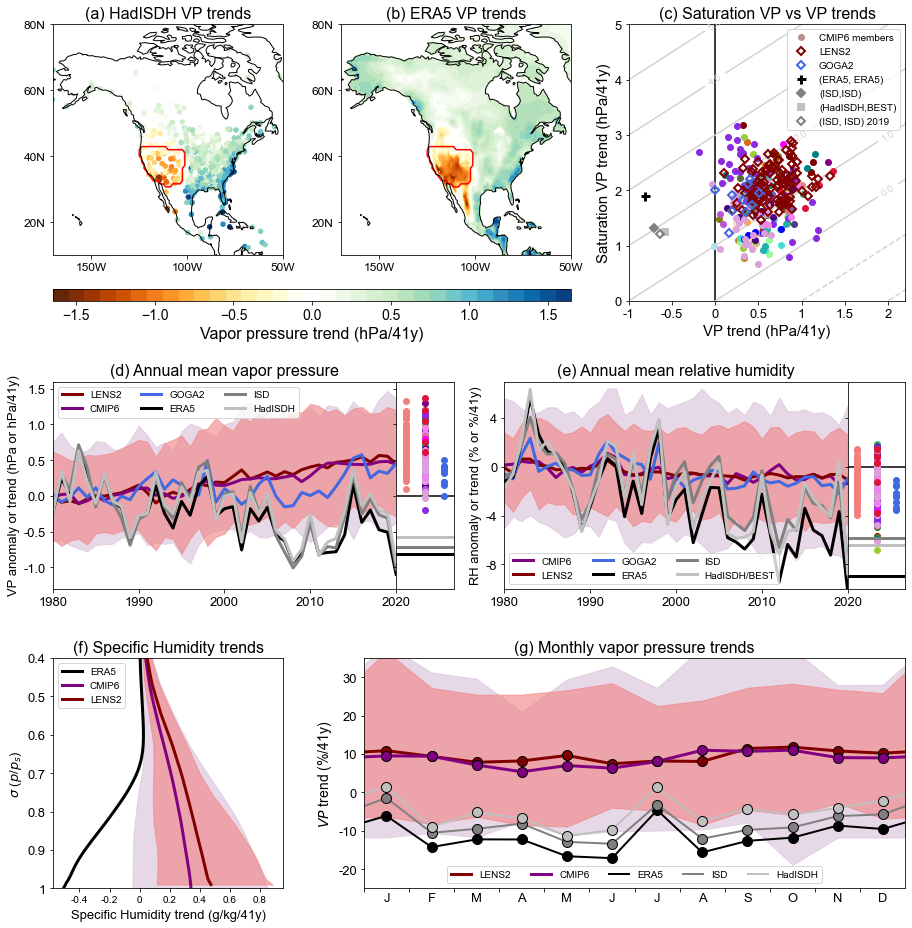

In [21]:
import importlib
importlib.reload(mymaps)

fig = plt.figure(figsize=(16,16))

#------ISD map
#ax = mymaps.contourmap_northamerica_scatter_pos(fig, isdmap.vp, isdmap.lons, isdmap.lats, 0.1,-1.5,1.5,'(a) ISD VP trends',
#                                                0.05,0.25,0.8,1,cmap='precip')
ax = mymaps.contourmap_northamerica_scatter_pos(fig, hadisdhmap.vp, hadisdhmap.lon, hadisdhmap.lat, 0.1, -1.6,1.6,'(a) HadISDH VP trends',
                                                0.05,0.25,0.8,1,cmap='precip')
ax = plt.contour(mask.lon, mask.lat, np.nan_to_num(mask), levels=[0,1], colors='red', linewidth=2)

#------ERA5 map
ax = mymaps.contourmap_northamerica_fill_pos(fig, era5map.vp*landfrac, era5map.lon, era5map.lat,0.1,-1.6,1.6,'(b) ERA5 VP trends',
                                           0.3,0.5,0.8,1,cmap='precip')
ax = plt.contour(mask.lon, mask.lat, np.nan_to_num(mask), levels=[0,1], colors='red', linewidth=2)
#---------------

#------ISD map
#ax = mymaps.contourmap_northamerica_scatter_pos(fig, isdmap.vp, isdmap.lons, isdmap.lats, 0.2,-2,2,'(b) ISD VP trends',
#                                                0.3,0.5,0.8,1,cmap='precip')
#ax = plt.contour(mask.lon, mask.lat, np.nan_to_num(mask), levels=[0,1], colors='red', linewidth=2)

ax = cbars.plotcolorbar(fig, 0.1, -1.6, 1.6,'Vapor pressure trend (hPa/41y)', 0.05,0.5,0.76,0.77,cmap='precip')
#---------------

#---------US southwest SVP versus VP                        
ax = setup_svp_vs_vp(0.55,0.79,0.76,1,'(c) Saturation VP vs VP trends')
#ax = setup_svp_vs_vp(0.55,0.79,0.76,1,'(c) Saturation $\overrightarrow{VP}$ vs $\overrightarrow{VP}$')
                        
for imodel in np.arange(0,cmip6_vp_sw_trend.model.size,1):
    datx = cmip6_vp_sw_trend.vp.isel(model=imodel)
    daty = cmip6_vp_sw_trend.svp.isel(model=imodel)
    datx = datx.sel(member=slice(1,nmems[imodel]))
    daty = daty.sel(member=slice(1,nmems[imodel]))
    ax.plot(datx, daty, "o", markersize=6, color=cmip6colors[imodel], label='CMIP6 members' if imodel == 0 else "")

ax.plot(lens2_vp_sw_trend.vp, lens2_vp_sw_trend.svp,"D", color='maroon', markerfacecolor='None', markersize=6, markeredgewidth=2,
       label='LENS2')
ax.plot(goga2_vp_sw_trend.vp, goga2_vp_sw_trend.svp,"D", color='royalblue', markerfacecolor='None', markersize=6, markeredgewidth=2,
       label='GOGA2')

ax.plot(era5_vp_sw_trend.vp, era5_vp_sw_trend.svp,"+", markerfacecolor='black', markersize=9,markeredgecolor='black', 
        markeredgewidth=3, label='(ERA5, ERA5)')
ax.plot(isd_vp_sw_trend.vp, isd_vp_sw_trend.svp,"D", markerfacecolor='gray', markersize=6, markeredgecolor='gray', 
        markeredgewidth=2, label='(ISD,ISD)')
ax.plot(hadisdh_vp_sw_trend.vp, best_vp_sw_trend.svp,"s", markerfacecolor='silver', markersize=6, markeredgecolor='silver',
        markeredgewidth=2, label='(HadISDH,BEST)')
ax.plot(isd_vp_sw_to2019_trend.vp, isd_vp_sw_to2019_trend.svp,"D", markerfacecolor='none', markersize=6, markeredgecolor='gray',
        markeredgewidth=2, label='(ISD, ISD) 2019')

#ax.plot(era5_vp_sw_trend.vp, best_vp_sw_trend.svp,"+", markerfacecolor='gray', markersize=9, markeredgecolor='gray', 
#        markeredgewidth=3, label='(ERA5,BEST)')
#ax.plot(isd_vp_sw_trend.vp, best_vp_sw_trend.svp,"D", markerfacecolor='gray', markersize=6, markeredgecolor='gray', 
#        markeredgewidth=2, label='(ISD, BEST)')
#ax.plot(isd_vp_sw_to2019_trend.vp, best_vp_sw_to2019_trend.svp,"D", markerfacecolor='None', markeredgecolor='gray', markersize=6,
#        markeredgewidth=2, label='(ISD, BEST) 2019')

ax.legend(loc='upper right')


#------Vapor pressure time series
ax = fig.add_axes([0.05,0.51,0.298,0.18])
ax.set_ylim(-1.3,1.6)
ax.set_xlim(1980,2020)
ax.set_yticks([-1,-0.5,0,0.5,1,1.5])
ax.set_yticklabels(['-1.0','-0.5','0.0','0.5','1.0','1.5'], fontsize=13)
ax.set_title('(d) Annual mean vapor pressure', fontsize=16)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=13)
ax.set_ylabel('VP anomaly or trend (hPa or hPa/'+str(np.int(nyears))+'y)', fontsize=13)

#---!!! Want to fix my annual averaging for these to be NaN's again.
cmip6_vp_sw_am = cmip6_vp_sw_am.where( cmip6_vp_sw_am.vp != 0, nan)

cmip6vpanoms_stacked = cmip6_vp_sw_am.vp.stack(z=('model','member'))
#cmip6vpanoms_stacked = cmip6vpanoms_stacked.where(cmip6vpanoms_stacked != 0, nan)
cmip6vpanoms_stacked = cmip6vpanoms_stacked.dropna('z')
cmip6vpanoms_stacked = cmip6vpanoms_stacked - cmip6vpanoms_stacked.sel(year=slice(1980,1990)).mean('year')
min95_cmip6 = cmip6vpanoms_stacked.quantile(0.025, dim='z')
max95_cmip6 = cmip6vpanoms_stacked.quantile(0.975, dim='z')

cmip6vpanoms_memmean = cmip6_vp_sw_am.vp.mean('member', skipna='True')
cmip6vpanoms_memmean = cmip6vpanoms_memmean - cmip6vpanoms_memmean.sel(year=slice(1980,1990)).mean('year')
cmip6vpanoms_modelmean = cmip6vpanoms_memmean.mean('model')

amip6vpanoms_memmean = amip6_vp_sw_am.vp.mean('member', skipna='True')
amip6vpanoms_memmean = amip6vpanoms_memmean - amip6vpanoms_memmean.sel(year=slice(1980,1990)).mean('year')
amip6vpanoms_modelmean = amip6vpanoms_memmean.mean('model')

lens2vpanoms_memmeani = lens2_vp_sw_am.vp - lens2_vp_sw_am.vp.sel(year=slice(1980,1990)).mean('year')
lens2vpanoms_memmean = lens2vpanoms_memmeani.mean('M')


goga2vpanoms = goga2_vp_sw_am.vp - goga2_vp_sw_am.vp.sel(year=slice(1980,1990)).mean('year')
goga2vpanoms_memmean = goga2vpanoms.mean('M')


min95lens2 = lens2vpanoms_memmeani.quantile(0.025, dim='M')
max95lens2 = lens2vpanoms_memmeani.quantile(0.975, dim='M')

ax.fill_between(min95_cmip6.year, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)
ax.fill_between(min95lens2.year, min95lens2, max95lens2, color='lightcoral', alpha=0.6)

ax.plot(lens2vpanoms_memmean.year, lens2vpanoms_memmean, color='maroon', linewidth=3, label='LENS2')
ax.plot(cmip6_vp_sw_am.year, cmip6vpanoms_modelmean, color='purple', linewidth=3, label='CMIP6')
#ax.plot(amip6_vp_sw_am.year, amip6vpanoms_modelmean, color='royalblue', linewidth=3, label='AMIP6')
ax.plot(goga2_vp_sw_am.year, goga2vpanoms_memmean, color='royalblue', linewidth=3, label='GOGA2')


ax.plot(era5_vp_sw_am.year, era5_vp_sw_am.vp - era5_vp_sw_am.vp.sel(year=slice(1980,1990)).mean('year'), 
        color='black', linewidth=3, label='ERA5')
ax.plot(isd_vp_sw_am.year, isd_vp_sw_am.vp - isd_vp_sw_am.vp.sel(year=slice(1980,1990)).mean('year'), 
        color='gray', linewidth=3, label='ISD')
ax.plot(hadisdh_vp_sw_am.year, hadisdh_vp_sw_am.vp - hadisdh_vp_sw_am.vp.sel(year=slice(1980,1990)).mean('year'),
        color='silver', linewidth=3, label='HadISDH')

ax.legend(loc='upper left', ncol=3)
#--------

#------vapor pressure trends
ax = fig.add_axes([0.348,0.51,0.05,0.18])
ax.set_ylim(-1.3,1.6)
ax.set_yticks([-1,-0.5,0,0.5,1,1.5])
ax.set_yticklabels(['','','','','',''], fontsize=12)
ax.set_xlim(0,3)
ax.set_xticks([])
ax.plot([0,3],[0,0], color='black')

ax.plot(lens2_vp_sw_trend.vp*0 + 0.5, lens2_vp_sw_trend.vp, "o", color='lightcoral')
for imodel in np.arange(0,cmip6_vp_sw_am.model.size,1):
    daty = cmip6_vp_sw_trend.vp.isel(model=imodel)
    daty = daty.dropna("member")
    ax.plot(daty*0 + 1.5, daty, "o", color=cmip6colors[imodel])

ax.plot(goga2_vp_sw_trend.vp*0 + 2.5, goga2_vp_sw_trend.vp,"o", color='royalblue')
    
ax.plot([0,3],[era5_vp_sw_trend.vp, era5_vp_sw_trend.vp], color='black', linewidth=3)
ax.plot([0,3],[isd_vp_sw_trend.vp, isd_vp_sw_trend.vp], color='gray', linewidth=3)
ax.plot([0,3],[hadisdh_vp_sw_trend.vp, hadisdh_vp_sw_trend.vp], color='silver', linewidth=3)
#------------------------------------------    

#------------------Relative humidity time series
ax = fig.add_axes([0.442,0.51,0.298,0.18])
ax.set_ylim(-10,7)
ax.set_yticks([-8,-4,0,4])
ax.set_yticklabels(['-8','-4','0','4'], fontsize=13)
ax.set_title('(e) Annual mean relative humidity', fontsize=16)
ax.set_xlim(1980,2020)
ax.set_xticks([1980,1990,2000,2010,2020])
ax.set_xticklabels(['1980','1990','2000','2010','2020'], fontsize=13)
ax.set_ylabel('RH anomaly or trend (% or %/'+str(np.int(nyears))+'y)', fontsize=13)

cmip6relhumanoms_stacked = cmip6_vp_sw_am.relhum.stack(z=('model','member'))
cmip6relhumanoms_stacked = cmip6relhumanoms_stacked.dropna('z')
cmip6relhumanoms_stacked = cmip6relhumanoms_stacked - cmip6relhumanoms_stacked.sel(year=slice(1980,1990)).mean('year')
min95_cmip6 = cmip6relhumanoms_stacked.quantile(0.025, dim='z')
max95_cmip6 = cmip6relhumanoms_stacked.quantile(0.975, dim='z')

cmip6relhumanoms_memmean = cmip6_vp_sw_am.relhum.mean('member', skipna='True')
cmip6relhumanoms_memmean = cmip6relhumanoms_memmean - cmip6relhumanoms_memmean.sel(year=slice(1980,1990)).mean('year')
cmip6relhumanoms_modelmean = cmip6relhumanoms_memmean.mean('model')

lens2relhumanoms_memmeani = lens2_vp_sw_am.relhum - lens2_vp_sw_am.relhum.sel(year=slice(1980,1990)).mean('year')
lens2relhumanoms_memmean = lens2relhumanoms_memmeani.mean('M')
min95lens2 = lens2relhumanoms_memmeani.quantile(0.025, dim='M')
max95lens2 = lens2relhumanoms_memmeani.quantile(0.975, dim='M')

goga2relhumanoms = goga2_vp_sw_am.relhum - goga2_vp_sw_am.relhum.sel(year=slice(1980,1990)).mean('year')
goga2relhumanoms_memmean = goga2relhumanoms.mean('M')


ax.fill_between(min95_cmip6.year, min95_cmip6, max95_cmip6, color='thistle', alpha=0.6)
ax.fill_between(min95lens2.year, min95lens2, max95lens2, color='lightcoral', alpha=0.6)
        
ax.plot(cmip6relhumanoms_modelmean.year, cmip6relhumanoms_modelmean, color='purple', linewidth=3, label='CMIP6')
ax.plot(lens2relhumanoms_memmean.year, lens2relhumanoms_memmean, color='maroon', linewidth=3, label='LENS2')
ax.plot(goga2relhumanoms_memmean.year, goga2relhumanoms_memmean, color='royalblue', linewidth=3, label='GOGA2')

ax.plot(era5_vp_sw_am.year, era5_vp_sw_am.relhum - era5_vp_sw_am.relhum.sel(year=slice(1980,1990)).mean('year'), 
        color='black', linewidth=3, label='ERA5')
ax.plot(isd_vp_sw_am.year, isd_vp_sw_am.relhum - isd_vp_sw_am.relhum.sel(year=slice(1980,1990)).mean('year'), 
        color='gray', linewidth=3, label='ISD')
ax.plot(hadisdh_relhum_am.year, hadisdh_relhum_am - hadisdh_relhum_am.sel(year=slice(1980,1990)).mean('year'),
        color='silver', linewidth=3, label='HadISDH/BEST')

ax.legend(loc='lower left', ncol=3)
#--------


ax = fig.add_axes([0.74,0.51,0.05,0.18])
ax.set_ylim(-10,7)
ax.set_yticks([-8,-4,0,4])
ax.set_yticklabels([])
ax.set_xlim(0,3)
ax.set_xticks([])
ax.plot([0,3],[0,0], color='black')

ax.plot(lens2_vp_sw_trend.relhum*0 + 0.5, lens2_vp_sw_trend.relhum, "o", color='lightcoral')
for imodel in np.arange(0,cmip6_vp_sw_am.model.size,1):
    daty = cmip6_vp_sw_trend.relhum.isel(model=imodel)
    daty = daty.dropna("member")
    ax.plot(daty*0 + 1.5, daty, "o", color=cmip6colors[imodel])

ax.plot(goga2_vp_sw_trend.relhum*0 + 2.5, goga2_vp_sw_trend.relhum, "o", color='royalblue')
    
ax.plot([0,3],[era5_vp_sw_trend.relhum, era5_vp_sw_trend.relhum], color='black', linewidth=3)
ax.plot([0,3],[isd_vp_sw_trend.relhum, isd_vp_sw_trend.relhum], color='gray', linewidth=3)
ax.plot([0,3],[hadisdh_relhum_trend, hadisdh_relhum_trend], color='silver', linewidth=3)
#------------------------------------------    


ax = fig.add_axes([0.05,0.25,0.2,0.2])
ax.set_ylim(-1,-0.4)
ax.set_yticks([-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4])
ax.set_yticklabels(['1','0.9','0.8','0.7','0.6','0.5','0.4'], fontsize=13)
#ax.set_xticks([-6e-4,-4e-4,-2e-4,0,2e-4,4e-4,6e-4,8e-4,10e-4])
#ax.set_xticklabels(['-6','-4','-2','0','2','4','6','8','10'], fontsize=13)
ax.set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_xticklabels(['-0.6','-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'])
#ax.set_xlabel('Specific Humidity trend ($\\times$10$^{-4}$kgm$^{-3}$/'+str(np.int(nyears))+'y)', fontsize=13)
ax.set_xlabel('Specific Humidity trend (g/kg/'+str(np.int(nyears))+'y)', fontsize=13)
ax.set_ylabel('$\sigma$ ($p$/$p_{s}$)', fontsize=13)
ax.set_title('(f) Specific Humidity trends', fontsize=16)

lens2_qprofile_min = lens2_qprofile.min('M') 
lens2_qprofile_min = lens2_qprofile_min.where( lens2_qprofile_min != 0, drop=True)
lens2_qprofile_max = lens2_qprofile.max('M')
lens2_qprofile_max = lens2_qprofile_max.where( lens2_qprofile_max != 0, drop=True)

cmip6_qprofile_em = cmip6_qprofile.mean('member', skipna=True)
cmip6_qprofile_mean = cmip6_qprofile_em.mean('model')

cmip6_qprofile_stacked = cmip6_qprofile.stack(z=("model","member"))
test = cmip6_qprofile_stacked.q_sw.isel(sigmaout = 0)
cmip6_qprofile_stacked = cmip6_qprofile_stacked.where( ~np.isnan(test), drop=True)
cmip6_qprofile_min = cmip6_qprofile_stacked.min('z')
cmip6_qprofile_max = cmip6_qprofile_stacked.max('z')

ax.plot(era5_qprofile.q_sw, -1.*era5_qprofile.sigma, color='black', linewidth=3, label='ERA5')

ax.fill_betweenx(-1.*cmip6_qprofile_stacked.sigmaout, cmip6_qprofile_min.q_sw, cmip6_qprofile_max.q_sw, color='thistle', alpha=0.6)


ax.fill_betweenx(-1.*lens2_qprofile_min.sigma, 
                 lens2_qprofile_min.__xarray_dataarray_variable__, 
                 lens2_qprofile_max.__xarray_dataarray_variable__, color='lightcoral', alpha=0.6)

ax.plot(cmip6_qprofile_mean.q_sw, -1.*cmip6_qprofile_mean.sigmaout, color='purple', linewidth=3, label='CMIP6')
lens2_qprofile_plot = lens2_qprofile.mean('M').__xarray_dataarray_variable__.where( lens2_qprofile.mean('M').__xarray_dataarray_variable__ != 0, drop=True)
ax.plot(lens2_qprofile_plot, -1.*lens2_qprofile_plot.sigma, color='maroon', linewidth=3, label='LENS2')
ax.legend(loc='upper left')




#-------Monthly trends
ax = lineplot.plotlinetime_j2d_monthly(fig, era5_vp_sw_monthly_trend*nan, 0.32,0.79, 0.25,0.45,
                                       '(g) Monthly vapor pressure trends',
                                       linecolor='black', ytitle='$VP$ trend (%/41y)', yticks=[-20,-10,0,10,20,30],
                                       yticklabels=['-20','-10','0','10','20','30'], yrange=[-25,35])

xvals = np.arange(0,12,1)+0.5
xpad = np.zeros([len(xvals)+2]).astype('float')
xpad[0] = xvals[len(xvals)-1]-12 ; xpad[len(xpad)-1] = xvals[0]+12 ; xpad[1:len(xpad)-1] = xvals

# CMIP6 shading
cmip6_mem_mean = cmip6_vp_sw_monthly_trend.mean('member', skipna=True)
cmip6_mean = cmip6_mem_mean.mean('model')

cmip6stacked = cmip6_vp_sw_monthly_trend.stack(z=("model","member"))
cmip6stacked = cmip6stacked.dropna("z")
mincmip6 = cmip6stacked.min("z")
maxcmip6 = cmip6stacked.max("z")
minpad = np.zeros([len(xvals)+2]).astype('float')
minpad[0] = mincmip6[len(xvals)-1] ; minpad[len(xpad)-1] = mincmip6[0] ; minpad[1:len(xpad)-1] = mincmip6
maxpad = np.zeros([len(xvals)+2]).astype('float')
maxpad[0] = maxcmip6[len(xvals)-1] ; maxpad[len(xpad)-1] = maxcmip6[0] ; maxpad[1:len(xpad)-1] = maxcmip6
ax.fill_between(xpad, minpad, maxpad, color='thistle', alpha=0.6)


# LENS2 shading
minlens2 = lens2_vp_sw_monthly_trend.min('M')
maxlens2 = lens2_vp_sw_monthly_trend.max('M')
minpad = np.zeros([len(xvals)+2]).astype('float')
minpad[0] = minlens2[len(xvals)-1] ; minpad[len(xpad)-1] = minlens2[0] ; minpad[1:len(xpad)-1] = minlens2
maxpad = np.zeros([len(xvals)+2]).astype('float')
maxpad[0] = maxlens2[len(xvals)-1] ; maxpad[len(xpad)-1] = maxlens2[0] ; maxpad[1:len(xpad)-1] = maxlens2
ax.fill_between(xpad, minpad, maxpad, color='lightcoral', alpha=0.6)
# End LENS2 shading

ax = lineplot.oplotlinetime_j2d_monthly(ax, lens2_vp_sw_monthly_trend.mean('M'), linecolor='maroon', label='LENS2', linewidth=3)
ax = lineplot.oplotlinetime_j2d_monthly(ax, cmip6_mean, linecolor='purple', label='CMIP6', linewidth=3)


ax = lineplot.oplotlinetime_j2d_monthly(ax, era5_vp_sw_monthly_trend, linecolor='black', label='ERA5', linewidth=2)
ax = lineplot.oplotlinetime_j2d_monthly(ax, isd_vp_sw_monthly_trend, linecolor='gray', label='ISD', linewidth=2)
ax = lineplot.oplotlinetime_j2d_monthly(ax, hadisdh_vp_sw_monthly_trend, linecolor='silver', label='HadISDH', linewidth=2)

ax.legend(loc='lower center', ncol=5)

fig.savefig(plotpath+'fig1.pdf', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'fig1.png', bbox_inches='tight', facecolor='white')